## Importing the input vectors

In [1]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import shap
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from functools import partial
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Run the data preparation notebook
testdf = np.load("npy_files/X_analog_feb_july.npy", allow_pickle=True)

X_analog = testdf[:,:-2].astype(np.float32)
anomaly_list = testdf[:,-1] #0 for normal. 1 for anomaly
timestamps = testdf[:,-2]
timestamps = pd.to_datetime(timestamps)


c:\Users\JoãoMarquesDias\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X_analog.shape

(9665, 16)

In [3]:
pd.DataFrame(X_analog[0,:]).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,8.642,9.736,9.728,9.32,8.926,8.558,8.228,6.05,6.15,3.855,0.04,0.04,0.04,0.0375,109.0,1942.0


#### Deciding the different sets' sizes and positions

#### Defining Autoencoder, loss and prediction functions

In [4]:
# Define input dimension
input_dim = X_analog.shape[1]

# Encoder: Three layers plus bottleneck
input_layer = Input(shape=(input_dim,), name='input')
encoded = Dense(128, activation='sigmoid', name='encoder_layer1')(input_layer)
encoded = Dense(64, activation='sigmoid', name='encoder_layer2')(encoded)
encoded = Dense(32, activation='sigmoid', name='encoder_layer3')(encoded)
bottleneck = Dense(12, activation='sigmoid', name='bottleneck')(encoded)

# Decoder: Three layers mirroring the encoder
decoded = Dense(32, activation='sigmoid', name='decoder_layer1')(bottleneck)
decoded = Dense(64, activation='sigmoid', name='decoder_layer2')(decoded)
decoded = Dense(128, activation='sigmoid', name='decoder_layer3')(decoded)
output_layer = Dense(input_dim, activation='sigmoid', name='output')(decoded)


autoencoder = Model(input_layer, output_layer)

# Custom loss function class
class SparseAutoencoderLoss(tf.keras.losses.Loss):
    def __init__(self, model, lambda_reg=1e-3, beta=1e-5, sparsity_target=0.05):
        super(SparseAutoencoderLoss, self).__init__()
        self.model = model
        self.lambda_reg = lambda_reg
        self.beta = beta
        self.sparsity_target = sparsity_target

    def get_layer_activations(self, data):
        layer_outputs = [layer.output for layer in self.model.layers if 'encoder' in layer.name or 'decoder' in layer.name or 'bottleneck' in layer.name]
        activation_model = Model(inputs=self.model.input, outputs=layer_outputs)
        activations = activation_model(data)
        return activations

    def call(self, y_true, y_pred):
        # Mean Squared Error
        mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

        # Frobenius norm
        frobenius_loss = 0
        for layer in self.model.layers:
            if hasattr(layer, 'kernel'):
                frobenius_loss += tf.reduce_sum(tf.square(layer.kernel))
        frobenius_loss *= self.lambda_reg

        # Kullback-Leibler divergence
        activations = self.get_layer_activations(y_true)
        kl_divergence = 0
        for activation in activations:
            rho_hat = tf.reduce_mean(activation, axis=0)  # Average activation per neuron
            kl_divergence += tf.reduce_sum( #reduce_sum takes the entire rho_hat vector and sums it up in the formula
            0.01 * tf.math.log(0.01 / (rho_hat + 1e-7)) +
            (1 - 0.01) * tf.math.log((1 - 0.01) / (1 - rho_hat + 1e-7))
            )
        kl_loss = self.beta * kl_divergence

        # Total loss
        return mse_loss + frobenius_loss + kl_loss
    

# Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    print("Accuracy = {}%".format(100*accuracy_score(~labels, predictions)))
    print("Precision = {}%".format(100*precision_score(~labels, predictions, pos_label=0)))
    print("Recall = {}%".format(100*recall_score(~labels, predictions, pos_label=0)))
    print("F1 Score = {}%".format(100*f1_score(~labels, predictions, pos_label=0)))

## Running the Autoencoder

#### Operator to tell the first cycle of a given month

In [5]:
np.where(timestamps.month == 4)[0][0]

np.int64(2954)

#### Boundary condition: the primordial run

Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 61.1366 - val_loss: 40.1545
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.8555 - val_loss: 37.3789
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.0901 - val_loss: 34.1436
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.4362 - val_loss: 30.4651
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.6477 - val_loss: 27.1700
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.3721 - val_loss: 24.5812
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4327 - val_loss: 22.6599
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.7100 - val_loss: 21.2381
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.1400 - val_loss: 20.1674
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6795 - val_loss: 19.3641
Epoch 11/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3007 - val_loss: 18.7564
Epoch 12/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st

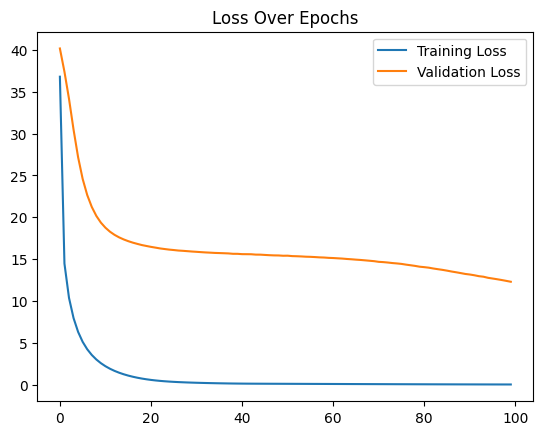

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Threshold:  0.16296068
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
pred_aux: (array([False,  True]), array([ 579, 4893]))


In [6]:
#Boundary condition: primordial run

# The last element contains the labels
labels = anomaly_list
# The other data points are the data
data = X_analog

#new variables for the moving window problem
test_loss = []
preds_list = []
val_preds_list = []
threshold_list = []
k_list = []
beta_list = []
batch_limits = []

normal_train_data = np.empty((0, 16), dtype=np.float32)  # Empty array with correct shape
anomalous_train_data = np.empty((0, 16), dtype=np.float32)
normal_val_data = np.empty((0, 16), dtype=np.float32)
anomalous_val_data = np.empty((0, 16), dtype=np.float32)


test_cycle_normalized = np.empty((1, 16), dtype=np.float32)
test_cycle = np.empty((1, 16), dtype=np.float32)
good_cycles = np.empty((1,16), dtype=np.float32)


# Determine the split index (see image below: the train and validation sets will use only good data. Mixed data is desirable for testing)
index_mar = 1180+1 #March 1st index (+1 bc 1st cycle is problematic)
index_apr = 2954
index_mai = 4193 
index_jun = 5815
index_jul = 7611
time_delta = 7 # how many days at a time you want to test
last_test_index = next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_mai]+pd.Timedelta(days=time_delta)) #Determine the last index of the test set
last_test_index_2 = next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_apr]+pd.Timedelta(days=2*time_delta))

# Split the data and labels
train_data = data[index_mar:index_apr].astype(np.float32)
val_data = data[index_apr:index_mai]
test_data = data[index_mai:].astype(np.float32) # Assuring we only test 1 week at a time
batch_limits.append([index_mai, last_test_index])


train_labels = labels[index_mar:index_apr]
train_len = len(train_labels)
val_labels = labels[index_apr:index_mai]
test_labels = labels[index_mai:] # Assuring we only test 1 week at a time

#Pass to boolean
train_labels = train_labels.astype(bool)
val_labels = val_labels.astype(bool)
test_labels = test_labels.astype(bool)

#Separate into normal and anomalous data
for i in range(len(train_labels)):
    if train_labels[i] == 0:
        normal_train_data = np.concatenate((normal_train_data, train_data[i:i+1, :]), axis=0)
    else:
        anomalous_train_data = np.concatenate((anomalous_train_data, train_data[i:i+1, :]), axis=0)

for i in range(len(val_labels)):
    if val_labels[i] == 0:
        normal_val_data = np.concatenate((normal_val_data, val_data[i:i+1, :]), axis=0)
    else:
        anomalous_val_data = np.concatenate((anomalous_val_data, val_data[i:i+1, :]), axis=0)


normal_train_data_normalized = np.zeros_like(normal_train_data)
test_data_normalized = np.zeros_like(test_data)
val_data_normalized = np.zeros_like(val_data)
normal_val_data_normalized = np.zeros_like(normal_val_data)
anomalous_val_data_normalized = np.zeros_like(anomalous_val_data)



scaler = MinMaxScaler()
normal_train_data_normalized[:,:7] = scaler.fit_transform(normal_train_data[:, :7].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,:7] = scaler.transform(test_data[:, :7].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,:7] = scaler.transform(val_data[:, :7].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

# Fit and transform sensor 2 (columns 7-13)
normal_train_data_normalized[:, 7:14] = scaler.fit_transform(normal_train_data[:, 7:14].flatten().reshape(-1, 1)).reshape(normal_train_data.shape[0], 7)
test_data_normalized[:,7:14] = scaler.transform(test_data[:, 7:14].flatten().reshape(-1, 1)).reshape(test_data.shape[0], 7)
val_data_normalized[:,7:14] = scaler.transform(val_data[:, 7:14].flatten().reshape(-1, 1)).reshape(val_data.shape[0], 7)

# Fit and transform Trun (column 14)
normal_train_data_normalized[:, 14] = scaler.fit_transform(normal_train_data[:, 14].reshape(-1, 1)).flatten()
test_data_normalized[:, 14] = scaler.transform(test_data[:, 14].reshape(-1, 1)).flatten()
val_data_normalized[:, 14] = scaler.transform(val_data[:, 14].reshape(-1, 1)).flatten()

# Fit and transform Tidle (column 15)
normal_train_data_normalized[:, 15] = scaler.fit_transform(normal_train_data[:, 15].reshape(-1, 1)).flatten()
test_data_normalized[:, 15] = scaler.transform(test_data[:, 15].reshape(-1, 1)).flatten()
val_data_normalized[:, 15] = scaler.transform(val_data[:, 15].reshape(-1, 1)).flatten()


#Separate into normal and anomalous data
for i in range(len(val_labels)):
    if val_labels[i] == 0:
        normal_val_data_normalized = np.concatenate((normal_val_data_normalized, val_data_normalized[i:i+1, :]), axis=0)
    else:
        anomalous_val_data_normalized = np.concatenate((anomalous_val_data_normalized, val_data_normalized[i:i+1, :]), axis=0)


# Compile the model with the custom loss
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=SparseAutoencoderLoss(model=autoencoder, lambda_reg=1e-5, beta=0.5, sparsity_target=0.01)
)

# Train the model
history = autoencoder.fit(
    x=normal_train_data_normalized,  # Input and target are the same for autoencoders
    y=normal_train_data_normalized,  # Input and target are the same for autoencoders
    epochs=100, 
    batch_size=30,
    validation_data=(normal_val_data_normalized, normal_val_data_normalized),
    verbose=1
)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()


# Classify an ECG as anomalous if the reconstruction error is greater than one standard deviation
reconstructions_val = autoencoder.predict(val_data_normalized)
val_loss = tf.keras.losses.mae(reconstructions_val, val_data_normalized)

if 1 in val_labels:
    y_true = (np.array(val_labels) != 0).astype(int)
    scores = np.array(val_loss)

    # 1. Calculate precision, recall, and thresholds.
    precision, recall, thresholds = precision_recall_curve(y_true, scores)

    # Note: precision and recall arrays have one extra element compared to thresholds.
    # We'll compute F1 scores for the thresholds only.
    # F1 = 2 * (precision * recall) / (precision + recall)
    f1_scores = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-8)  # added epsilon for safety
    # 2. Identify the best threshold (maximizing F1 score)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
##############################################################REPLACE TYKEY'S FENCES WITH 99-PERCENTILE
    # Compute quartiles and IQR
    Q1 = np.percentile(val_loss, 25)
    Q3 = np.percentile(val_loss, 75)
    IQR = Q3 - Q1
    # Compute k
    k = (best_threshold - Q3) / IQR
    #beta = best_threshold/np.percentile(val_loss, 99)
    
else:
    best_threshold = np.percentile(val_loss, 99) #REPLACE max(val_loss) by 99-percentile

    # Compute quartiles and IQR
    Q1 = np.percentile(val_loss, 25)
    Q3 = np.percentile(val_loss, 75)
    IQR = Q3 - Q1
    # Compute k
    k = (best_threshold - Q3) / IQR
    #beta = best_threshold/np.percentile(val_loss, 99)

threshold_list.append(best_threshold)
#beta_list.append(beta)
k_list.append(k)
print("Threshold: ", best_threshold)



# Calculate the reconstruction loss for the anomalous test data
reconstructions_test = autoencoder.predict(test_data_normalized)
val_pred = predict(autoencoder, val_data_normalized, best_threshold).numpy()
pred_aux = predict(autoencoder, test_data_normalized, best_threshold).numpy()
preds_list = np.concatenate((preds_list, pred_aux), axis=0)
'''pred_val_aux = val_labels #predict(autoencoder, normal_val_data_normalized, best_threshold)
val_preds_list = np.concatenate((val_preds_list, pred_val_aux), axis=0)'''
print("pred_aux:", np.unique(pred_aux, return_counts=True))

test_loss = tf.keras.losses.mae(reconstructions_test, test_data_normalized).numpy()


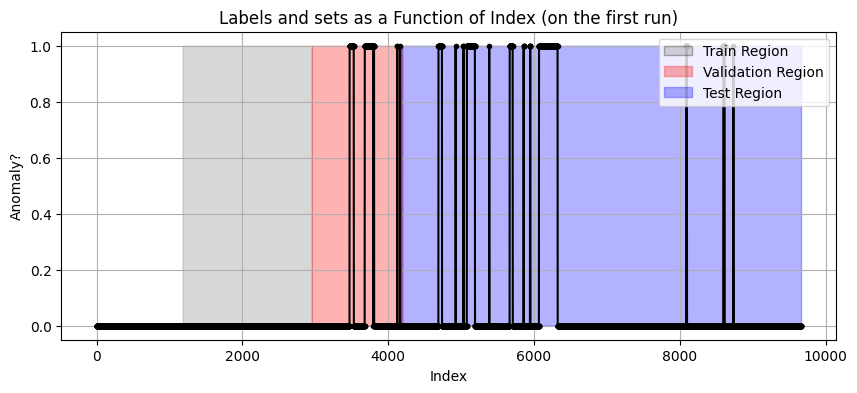

In [7]:
labels_int = [int(label) for label in labels]

# Plot the labels as a function of the index
plt.figure(figsize=(10, 4))
plt.plot(labels_int, '.-', color='black', label='Labels')
plt.fill_between(range(len(labels)), 0, 1, where=(np.arange(len(labels)) >= index_mar) & (np.arange(len(labels)) < index_apr), color='gray', alpha=0.3)
plt.fill_between(range(len(labels)), 0, 1, where=(np.arange(len(labels)) >= index_apr) & (np.arange(len(labels)) < index_mai), color='red', alpha=0.3)
plt.fill_between(range(len(labels)), 0, 1, where=(np.arange(len(labels)) >= index_mai), color='blue', alpha=0.3)
legend_elements = [Patch(facecolor='gray', edgecolor='black', alpha=0.3, label='Train Region'),
                   Patch(facecolor='red', edgecolor='r', alpha=0.3, label='Validation Region'),
                   Patch(facecolor='blue', edgecolor='b', alpha=0.3, label='Test Region')]
plt.legend(handles=legend_elements, loc='upper right')

plt.xlabel('Index')
plt.ylabel('Anomaly?')
plt.title('Labels and sets as a Function of Index (on the first run)')
plt.grid(True)
plt.show()

#### Plotting the threshold with the test sets

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


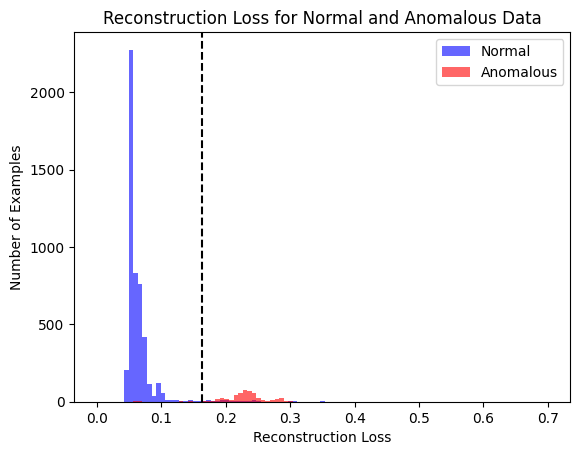

In [8]:
normal_test_data_normalized = np.empty((0, 16), dtype=np.float32)  # Empty array with correct shape
anomalous_test_data_normalized = np.empty((0, 16), dtype=np.float32)
for i in range(len(test_labels)):
    if test_labels[i] == 0:
        normal_test_data_normalized = np.concatenate((normal_test_data_normalized, test_data_normalized[i:i+1, :]), axis=0)
    else:
        anomalous_test_data_normalized = np.concatenate((anomalous_test_data_normalized, test_data_normalized[i:i+1, :]), axis=0)
reconstructions_test_normal = autoencoder.predict(normal_test_data_normalized)
normal_test_loss = tf.keras.losses.mae(reconstructions_test_normal, normal_test_data_normalized)

try:
    reconstructions_test_anomalous = autoencoder.predict(anomalous_test_data_normalized)
    anomalous_test_loss = tf.keras.losses.mae(reconstructions_test_anomalous, anomalous_test_data_normalized)

    # Plot both losses on the same histogram
    plt.hist(normal_test_loss, bins = np.linspace(0, 0.7, 100), alpha=0.6, color='blue', label='Normal')
    plt.hist(anomalous_test_loss, bins = np.linspace(0, 0.7, 100), alpha=0.6, color='red', label='Anomalous')

    plt.xlabel("Reconstruction Loss")
    plt.ylabel("Number of Examples")
    plt.legend(loc='upper right')
    plt.title("Reconstruction Loss for Normal and Anomalous Data")
    plt.axvline(x=best_threshold, color='black', linestyle='--')
    #plt.ylim((0, 40))
    plt.show()
except:
    print("No anomalies in the test set")

## Metrics and Confusion Matrix

In [9]:
len(data[next(i for i, ts in enumerate(timestamps) if ts > timestamps[index_mai]+pd.Timedelta(days=time_delta)):])


5134

Optimal Threshold: 0.1630
Confusion Matrix:
 [[4881   86]
 [  12  493]]
Accuracy = 98.21%
Precision = 85.15%
Recall = 97.62%
F1 Score = 90.96%


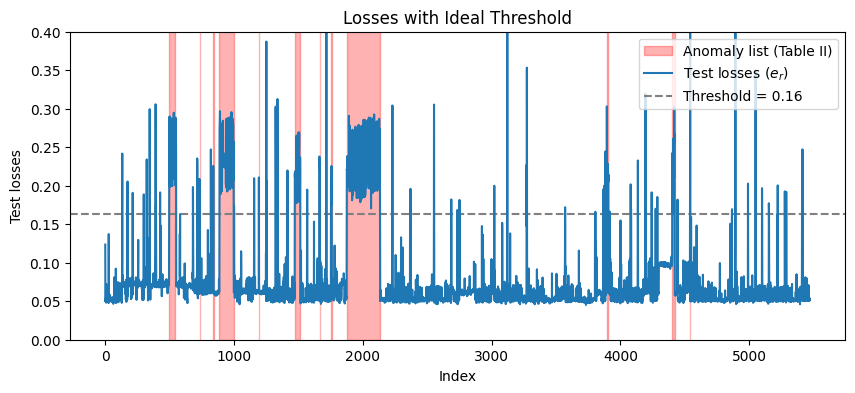

In [30]:
anomaly_list_binary = np.array(test_labels == 1, dtype=int)

# Compute confusion matrix
conf_matrix = confusion_matrix(anomaly_list_binary, pred_aux==False)

# Display results
print(f"Optimal Threshold: {best_threshold:.4f}")
print("Confusion Matrix:\n", conf_matrix)
TN, FP, FN, TP = conf_matrix.ravel()

# Computing metrics
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = (TP / (TP + FP)) if (TP + FP) > 0 else 0
recall = (TP / (TP + FN)) if (TP + FN) > 0 else 0
f1_score = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0
print(f"Accuracy = {100*accuracy:.2f}%")
print(f"Precision = {100*precision:.2f}%")
print(f"Recall = {100*recall:.2f}%")
print(f"F1 Score = {100*f1_score:.2f}%")



# Plot the original and filtered data
plt.figure(figsize=(10, 4))
plt.fill_between(range(len(test_labels)), 0, max(test_loss), where=np.array(test_labels) == 1, color='red', alpha=0.3, label='Anomaly list (Table II)')
plt.axhline(y=best_threshold, color='gray', linestyle='--')
plt.plot(test_loss, label="Test losses ($e_r$)", linestyle='-') 
custom_legend = [Line2D([0], [0], color='gray', linestyle='--', label=f"Threshold = {best_threshold:.2f}")]
plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + custom_legend, loc='upper right')
plt.title('Losses with Ideal Threshold')
plt.ylim(0,0.4)
plt.xlabel('Index')
plt.ylabel('Test losses')
plt.show()

Confusion Matrix = 
| True Negatives |     False Positives |
| -------------  |  --------------- |
| **False Negatives**   |  **True Positives** |